<a href="https://colab.research.google.com/github/myrronaguila/analyze_sqc/blob/main/Plots/1Q_Transmon_Calibration_Flux_Dependences_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Flux-tunable Qubit Characterization Part 2
by Myrron Albert Callera Aguila, PhD (First updated 20231108)

This notebook is focused on extracting key points that give the flux-tunable behavior of the qubit. We detailed extraction methods so that parabolic or sinusoidal waves can be plotted on top of the 2D flux dependent maps. By performing spectroscopies of the qubit-resonator response to continuous microwave, key features such as qubit frequency shifts and resonator decay are well-characterized.



## Imported Python Packages

In [1]:
#Download packages
!pip install lmfit==1.2.2 #updated lmfit
!pip install git+https://github.com/sebastianprobst/resonator_tools.git #resonator_tools
!pip install PeakUtils
#https://stackoverflow.com/questions/51342408/how-do-i-install-python-packages-in-googles-colab
#https://github.com/pypa/pip/issues/539

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 13.7 MB/s eta 0:00:00
  Cloning https://github.com/sebastianprobst/resonator_tools.git to /tmp/pip-req-build-bhdi4i0q
  Running command git clone --filter=blob:none --quiet https://github.com/sebastianprobst/resonator_tools.git /tmp/pip-req-build-bhdi4i0q
  Resolved https://github.com/sebastianprobst/resonator_tools.git to commit eb382e3cf570a46ed5500375dd0b9d82dbe0ea54
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 2.7 MB/s eta 0:00:00
  Created wheel for resonator-tools: filename=resonator_tools-0.1-py3-none-any.whl size=24067 sha256=b07e8116032b4089a4910715c9ad342f891d5440e740a97c73a5280613462270
  Stored in directory: /tmp/pip-ephem-wheel-cache-cc7kwhta/wheels/41/a7/eb/7239c25af7ab4901ddc5600096c0405053a2f5adae074d4d74
Successfully built resonator-tools


In [ ]:
!pip list #check if resonator-tools is installed

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.8.6
aiosignal                        1.3.1
alabaster                        0.7.13
albumentations                   1.3.1
altair                           4.2.2
anyio                            3.7.1
appdirs                          1.4.4
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array-record                     0.5.0
arviz                            0.15.1
asteval                          0.9.31
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.0
attrs                            23.1.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.13.1
backcall                         0.2.0
beautifulsoup4                   4.11.2
b

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import lmfit as lm
import pandas as pd
import peakutils
import time as time

In [3]:
from uncertainties import ufloat #for uncertainties
from lmfit import Model, Parameters #for modelling
from lmfit.models import LorentzianModel, ConstantModel #for Lorentzian fits
from scipy.io import loadmat, savemat  # this is the SciPy module that loads mat-files
from resonator_tools import calibration
from resonator_tools import circuit

In [4]:
#fundamental constants
# set idea
#fundamental constants. obtained from wiki rather than fundamental constants
#from scipy.constants import epsilon_0, mu_0, hbar, k
e0 = 8.8541878128E-12 #F m^s
mu0 = 1.25663706212E-16 #N A^-2
kb = 1.380649E-23 #J K^-1
hbar = 1.054571817E-34 #J s
c = 299792458 # speed of light m s^-2
phi0 = 2.067833848E-15 #Wb
h = 2*np.pi*hbar

## Extracting Flux-dependent Peaks/Dips in Qubit/Resonator spectroscopy

Extracting those fitted flux peaks are non-trivial. The first guess would be to do flux-dependent resonator spectroscopy which gives flux tunability accurate within 100 MHz. The other is performing flux-tunable qubit spectroscopy using two continous tone measurements. Both measurement requires 2D map of the qubit amplitude at varying frequency and induced magnetic field. They require (1) Lorentzian fits of the qubit spectrocopic peaks for better precision of the measured peaks and (2) characteristic of the transmission as characterized in resonator spectrocopy baseline. They are trivial standard operating procedures shown in the literature ever since flux tunable qubits are introduced. These extraction tricks, when considering the offsets due to external flux lines, can represent the flux compensation matrix needed to perform idling and pulse compensation strategies.

Here, we list how we extract those key data using (1) numpy methods and (2) LMfit built-in functions. Hopefully, the process would simplify the peak extraction, which contributes to qubit autocalibration.

##Method 1: Using minimum and maximum amplitude.

This method is fast at the expense of being imprecise and heavily dependent on sample points. This method is also susceptible to noisy signals, which can distort the periodicity. This can be done by extracting the peak and dip in 1D numpy array.

### Data Handling and Image Sizing Packages

In [22]:
def cm_to_inch(x):
  """
  Convert cm to inch
  """
  return x/2.54

def get_data_from_mat(filename):
    """
    Retrieve Data from .mat file

    Parameters
    ----------
    filename : string
        filename of data.

    Returns
    -------
    dict: dictionary

    """
    df = loadmat(filename)
    return df

def freq_range(x_data, x_a, x_b):
    """Equivalent of Numpy as making range in frequencies (MHz)"""
    idx_a = np.where(x_data >= x_a)[0][0] # getting the first element of min data
    idx_b = np.where(x_data <= x_b)[0][-1] # getting the last element of max data
    return x_data[idx_a:(idx_b+1)], idx_a, int(idx_b+1)

def lst_xyrange(lst_xdata, lst_ydata, x_a, x_b):
    """
    Extract a smaller list of 1D arrays of data

    Parameters
    ----------
    lst_xdata : list of 1D arrays
        list of x-data.
    lst_ydata : list of 1D arrays
        list of y-data.
    x_a : float
        lower frequency.
    x_b : float
        higher frequency.

    Returns
    -------
    Data Analysis.
    """
    lst_xdat = []
    lst_ydat = []
    n = len(lst_xdata)
    for i in range(n):
        """Get minimum and maximum range possible"""
        idx_a = np.where(lst_xdata[i] >= x_a)[0][0]
        idx_b = np.where(lst_xdata[i] <= x_b)[0][-1]
        # print(idx_a)
        # print(idx_b)
        """Append Empty array"""
        lst_xdat.append(lst_xdata[i][idx_a:idx_b])
        lst_ydat.append(lst_ydata[i][idx_a:idx_b])
    return lst_xdat, lst_ydat

def find_nearest(array, value):
    """Find index and element to an array to which its value is nearest to the
    reference value"""
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx, array[idx]

def get_mins_from_2Darray(z2D, x, par_arr, min='dip'):
  """
  Extract peak parameters per parameter in 2D array
  Input :
    z2D : 2D numpy array
      amplitude in 2D array:
      2D numpy array shape = (len(par_arr), len(x))
    x : 1D numpy array
      frequency spectrum
    par_arr : 1D numpy array
      varied parameters for analysis
    min : string
      'dip' => minimum
      'peak' => maximum
  """
  n = len(par_arr)
  par_extract = np.ones(n)
  for i in range(len(par_arr)):
    if min == 'dip':
      idx=find_nearest(array=z2D[i], value=np.amin(z2D[i]))[0]
    else:
      idx=find_nearest(array=z2D[i], value=np.amin(z2D[i]))[0]
    par_extract[i] = x[idx]
  return par_extract

def detect_mins(x_arr, y_arr, string, args):
    """
    get peaks and dips above a threshold amplitude for a 1D-array using peak
    utils. Useful for getting peaks in X and Y axis. Very susceptible to noise
    unless filter functions are implemented.

    Parameters
    ----------
    x_arr : 1D numpy array
        1D data array.
    y_arr : 1D numpy array
        1D data array.
    string : 1D numpy array
        string=peaks.
        string=dips.
    args : 1D numpy array
        args[0] = threshold amplitude
        args[1] = minimum spacing
        args[2] = number of max peaks

    Returns
    -------
    min_list : list of list of values
        min_list[0] = list of indices
        min_list[1] = list of x-value floats
        min_list[2] = list of y-value floats
    """
    if string == 'peaks':
        indices = peakutils.indexes(y_arr, thres=args[0], min_dist=args[1])
        pass
    elif string=='dips':
        y_arr_mod = -1*y_arr
        indices = peakutils.indexes(y_arr, thres=np.abs(args[0]), min_dist=args[1])
    else:
        indices = []
    return indices

"""-----------------Data Retrieval from LMFit Functions---------------------"""
def info_retriv(fitpars, string):
    """
    retrieve tuple of fit parameters (nominal values and errors) from fit

    Parameters
    ----------
    fitpars : list of dictionaries
        format = [{}].
    string : TYPE
        DESCRIPTION.

    Returns
    -------
    val_1D : 1D numpy array
        Nominal Values of parameters.
    err_1D : 1D numpy array
        Stderr of parameters.

    """
    """fitpars is an array of dictionaries of values"""
    """string would be the retrieved filename of the dictionaries"""
    """For memory efficiency, slicing the variable would be better rather than
    two list comprehension"""
    val_1D = np.asarray([fitpars[i][string][0] for i in range(len(fitpars))])
    err_1D = np.asarray([fitpars[i][string][1] for i in range(len(fitpars))])
    """Output are values of both errors and 1D string"""
    return val_1D, err_1D

def dict_retriv_form(data_dic, ctrl_dic, save):
    """
    Repackage list of dictionaries to saveable dictionary

    Parameters
    ----------
    dic : dictionary
        Data from Dictionary after autofit.
    var_dic : Variable Dic
        Dictionary with variables
    save : list of strings
        save[0]='Y': save data
        save[0]='N': do not save
        save[1]='filename of .mat'

    Returns
    -------
    None.

    """

    #acquire the list of names for a dictionary
    names = list(data_dic[0].keys())

    #add control list in front of the list
    var_str = list(ctrl_dic.keys())[0]
    names.insert(0, var_str)

    #create a new dictionary of parameters
    dic_new = {names[i]: ctrl_dic[var_str] if names[i]==var_str else
               info_retriv(fitpars=data_dic, string=names[i]) for i in range(len(names))}

    #save dictionary if necessary
    if save[0]=='Y':
        savemat(file_name = save[1]+'.mat',mdict=dic_new)

    return dic_new

def conc_val_er(ar1, ar2, er1, er2):
    #Reference: https://stackoverflow.com/questions/1720421/how-do-i-concatenate-two-lists-in-python
    return [*ar1, *ar2], [*er1, *er2]

### Cosine Fit

We use the cosine fit for rough estimation of the qubit period. In flux-driven cavity peaks, the cavity period gives a good idea of the qubit period within 100 MHz accuracy, which is a good guess for future fitting. The minimum and maximum cavity resonant frequency can be used to resolve $E_{j1}$ and $E_{j2}$ which are good guesses for the split transmon Hamiltonian.

$$f_{c}(V_{flux})=f_{c,0}+\chi_{Amp}cos(m(V_{DC}) - \theta_e)$$

where $m=\frac{2\pi}{V_{c}}$ and $\theta_{e} = mV_{e}$

In [39]:
def guess_cos(xdata, ydata):
    """
    Guess function

    Parameters
    ----------
    x : 1d numpy array
        x-data.
    y : 1d numpy array
        y-data.

    Returns
    -------
    period, amp, phi0, c.

    """

    """y-offset"""
    b = np.average(ydata)

    """phi_0"""
    idx = np.where(ydata==np.amax(ydata))[0][0]
    phi0 = 2*np.pi*(xdata[idx]/(xdata[-1]-xdata[0]))
    #guess for phi_0 is erroneous

    """period_ver 1"""
    idx_0, cn = find_nearest(array=ydata, value = b)
    x_0 = xdata[idx_0]
    #print(x_0)
    idx_max, cmax = find_nearest(array=ydata, value = np.amax(ydata))
    x_max = xdata[idx_max]
    #print(x_max)
    period = 2*np.pi/(4*np.abs(x_max - x_0))

    """Amplitude"""
    amp = np.amax(ydata) - b

    """Make adictionary"""
    dict_g = {'period': period,
              'amp': amp,
              'phi0': phi0,
              'b': b}

    return dict_g

def cos_func(xdata, period, amp, phi0, b):
    """
    Cosine Function

    Parameters
    ----------
    x : TYPE
        DESCRIPTION.
    period : TYPE
        DESCRIPTION.
    amp : TYPE
        DESCRIPTION.
    phi0 : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    return amp*np.cos(period*xdata - phi0) + b

def lm_cos_fit(xdata, ydata, show=['N','N']):
    """

    Fit cosine fit

    Parameters
    ----------
    xdata : TYPE
        DESCRIPTION.
    ydata : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """

    #guess function
    dic_m = guess_cos(xdata=xdata, ydata=ydata)
    p = dic_m['period']
    a = dic_m['amp']
    ph = dic_m['phi0']
    ba = dic_m['b']

    #model
    mod = Model(cos_func)

    #old way
    pars = Parameters()

    # add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
    pars.add_many(('period', p, True, 0.0, 1/(xdata[1]-xdata[0])),
                    ('amp', a, True, 0.0, 2*a),
                    ('phi0', ph, True, -np.pi, np.pi),
                    ('b', ba, True, np.amin(ydata), np.amax(ydata)))

    """Amplitude Fit with fit"""
    init = mod.eval(pars, xdata=xdata)
    out = mod.fit(ydata, pars, xdata=xdata)

    if show[0] == 'Y':
        #print out fitting report
        print(out.fit_report(min_correl =0.3))

    if show[1] == 'Y':
        #show amplitude fit
        wfig=8.6
        fig = plt.figure(constrained_layout=True, figsize=(1*cm_to_inch(wfig),
                                                    1*cm_to_inch(wfig)))
        spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
        ax1 = fig.add_subplot(spec[0, 0]) #photon power dependence
        ax1.plot(xdata, ydata)
        ax1.plot(xdata, init, '--', label='initial fit')
        ax1.plot(xdata, out.best_fit, '-', label='best fit')
        ax1.set_xlabel('Period')
        ax1.set_ylabel('Amplitude')
        ax1.legend()

        plt.show()

    """--Retrieve String from the fit function--output is x-fit and y-fit-------"""
    name = ['period', 'amp', 'phi0','b']
    # strange dictionary
    out_dict_val_stderr = {name[i]: [out.params[name[i]].value,
                                    out.params[name[i]].stderr] for i in range(len(name))}

    return out.best_fit, out_dict_val_stderr

### Extract Data for fitting

Retrieve data from dictionary

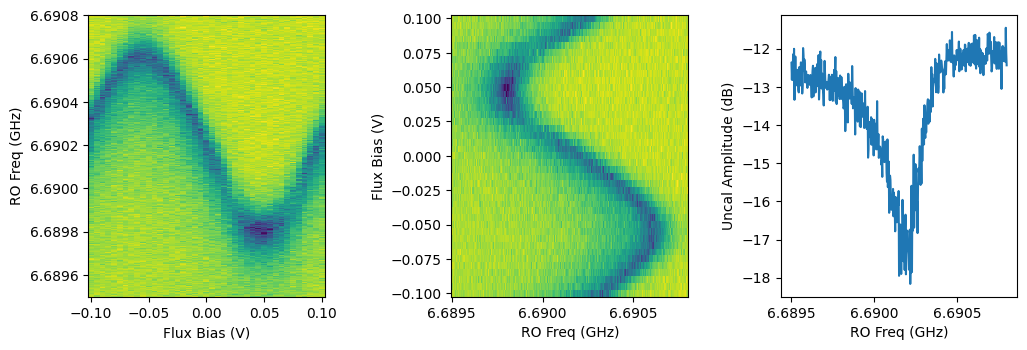

In [40]:
fname_res_flux = 'Flux-Dependent Bias IF=500 Freq=6691 GHz S21-FreqResp_vs_ProbePow'
#get flux amplitude and phase from resonator data
dict_flux_C2 = get_data_from_mat(fname_res_flux)
flux_amp2D_dB = dict_flux_C2['ZZA']  #in dB, ndarray (501, 41)
flux_phase2D = dict_flux_C2['ZZP'] #in radians, ndarray (501, 41)

"""variable dimensions"""
flux_va = dict_flux_C2['x'][0] #flux bias in Volts, 41 points
f_ro_f = dict_flux_C2['y'][0] #readout frequency, 501 points

wfig=8.6
fig = plt.figure(constrained_layout=True, figsize=(3*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
ax1 = fig.add_subplot(spec[0, 0]) #photon power dependence
ax2 = fig.add_subplot(spec[0, 1]) #Frequency vs cavity amplitude at sweetpoint
ax3 = fig.add_subplot(spec[0, 2]) #Frequency vs cavity amplitude at sweetpoint

ax1.pcolormesh(flux_va, f_ro_f, flux_amp2D_dB) #in dB
ax1.set_xlabel('Flux Bias (V)')
ax1.set_ylabel('RO Freq (GHz)')

ax2.pcolormesh(f_ro_f, flux_va, np.transpose(flux_amp2D_dB)) #in dB
ax2.set_xlabel('RO Freq (GHz)')
ax2.set_ylabel('Flux Bias (V)')

ax3.plot(f_ro_f, flux_amp2D_dB[:, 20]) #spectrum at flux=0 V
ax3.set_xlabel('RO Freq (GHz)')
ax3.set_ylabel('Uncal Amplitude (dB)')
plt.show()

Get minimum peaks from 2D amplitude maps. Suppose we get the amplitude, and the amplitude has a clear dip, we extract the dip per qubit frequency and analyze their dependences.

[6.6903216 6.6903788 6.6904204 6.6904568 6.6905192 6.6905452 6.690553
 6.6906102 6.6905842 6.6905998 6.6905894 6.690605  6.690566  6.6905218
 6.6904958 6.6904412 6.6903944 6.6903424 6.6903346 6.6902722 6.6902176
 6.6901396 6.6900876 6.690085  6.6899628 6.6898952 6.6898536 6.6898198
 6.6898198 6.6898016 6.6898068 6.6898094 6.6898354 6.689838  6.6898588
 6.6899498 6.6900148 6.6900694 6.6901084 6.6901994 6.6902436]
[[Model]]
    Model(cos_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 41
    # variables        = 4
    chi-square         = 2.6525e-08
    reduced chi-square = 7.1690e-10
    Akaike info crit   = -859.508398
    Bayesian info crit = -852.654110
    R-squared          = 0.99197934
[[Variables]]
    period:  30.4640358 +/- 0.24476185 (0.80%) (init = 24.1661)
    amp:     3.9884e-04 +/- 6.1022e-06 (1.53%) (init = 0.0003914585)
    phi0:   -1.67345697 +/- 0.01489553 (0.89%) (init = -2.042035)
    b:       6.69021899 

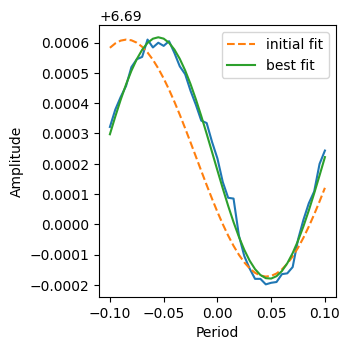

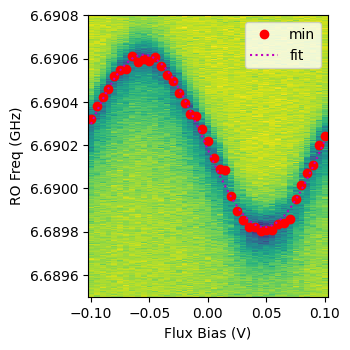

In [41]:
#get minimum frequencies
freq_min_dip = get_mins_from_2Darray(z2D=np.transpose(flux_amp2D_dB), x=f_ro_f, par_arr=flux_va, min='dip')

#perform cosine fit to determine offset
freq_fit1, dict_cos1 = lm_cos_fit(xdata=flux_va, ydata=freq_min_dip, show=['Y','Y'])

#plot data

wfig=8.6
fig = plt.figure(constrained_layout=True, figsize=(1*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
ax1 = fig.add_subplot(spec[0, 0]) #photon power dependence with super-imposed min and fits
ax1.pcolormesh(flux_va, f_ro_f, flux_amp2D_dB) #in dB
ax1.plot(flux_va, freq_min_dip, 'ro', label='min') #superimposed peak minimum
ax1.plot(flux_va, freq_fit1, 'm:', label='fit')
ax1.set_xlabel('Flux Bias (V)')
ax1.set_ylabel('RO Freq (GHz)')
ax1.legend(loc='best')
plt.show()

###Extracting mutual inductance from flux lines

In real experiments, the transmon is biased at the flux lines, converting the applied voltage to a current $I$ that creates a magnetic field from the mutual inductance $M$. To simplify the calibration and map it to a flux, one period of the flux line is equivalent to a flux quanta $\Phi_{0}$, hence simplifying the calibration from voltage to flux. The component also helps reveal the mutual inductance, to see if it helps improve the design of the flux line.

$$\frac{\pi (\Phi-\Phi_e)}{\Phi_0} = \frac{(V-V_e)}{V_{c}} = \frac{(I-I_e)}{I_c}$$

Modelling the flux line as a quantized inductor, the Mutual inductance is equivalent to the Josephson inductance required to the qubit to get a full period of the qubit).

$$L_M = \frac{\Phi_0}{I_{c}}$$

As normal flux pulses are controlled by AWG voltages $V_{DC}$ starting from 0 volts that are attenuated by the flux line with power attenuation $A_{tot}$ with a characteristic impedance $Z_{0}=50 \Omega$, the bias voltage $V_{c}$ felt by the bias line has the following relation with the $I_{c}$ and $V_{DC}$:

$$V_{c} = \sqrt{A_{tot}} (V_{DC,period}) = I_{c}Z_{0} \rightarrow I_{c} = \frac{\sqrt{A_{tot}} (V_{DC,period})}{Z_{0}}$$

Given this relation, one can calibrate the peaks well. In the case of symmetric josephson Junction though, these types of measurements must be carried out with cavity measurements to make the fits easier.

In [55]:
def dB_to_mag(x):
  """Convert dB to S21 magnitude"""
  return 20*np.log10(x)

def m_to_Vc(m):
  """Extract Vperiod from 2pi/period"""
  return 2*np.pi/m

def theta0_to_offset(m, theta_e):
  """Extract offset voltage from period and phi"""
  return theta_e/m

def Vdc_to_Ic(Vdc, attn):
  """
  Convert Ic from Vdc voltage
  assume symmetric period, and an impedance of 50 ohm
  Input:
    Vdc : float
      Vdc where periodicity is obtained
    Voffs: float
      Voffset
    attn : float
      Attenuation in dB
  """
  exp = np.sqrt(dB_to_mag(attn))*(Vdc)/50
  return exp

def Lm(Ic):
  """
  Estimate Mutual Inductance from flux quantum
  1. useful in debugging M from design to test M'
  input :
    Ic : float
      critical current where we get one flux period of the qubit
  return :
    float
  """
  return phi0/Ic

def Voffs_to_phi_e(Ie, Ic):
  """
  Convert flux offset to external flux quanta:
  input :
    x : float
      flux offset
  """
  phi_e = phi0*(Ie/Ic)
  """
  note that phi_e and phi_0 ignores the np.pi that was used by the transmon
  community to identify phase.
  """
  return phi_e

def Vdc_to_flux_quanta(Vdc, Vc, Voffs):
  """Convert Bias voltage to flux quanta"""
  phi_arr = phi0*(Vdc-Voffs)/Vc
  return phi_arr

Extract $V_{period}$ and $V_{e}$ from the fit. Here, we assume that the input attenuation for the flux line is 20 dB. We also report the mutual inductance $L_{m}$ for design interest.


In [89]:
# the m here refers to the sensitivity to bias voltage to the room temperature DC voltage
Vc1 = m_to_Vc(ufloat(dict_cos1['period'][0], dict_cos1['period'][1]))
Voffs1 = theta0_to_offset(ufloat(dict_cos1['period'][0], dict_cos1['period'][1]),
                       ufloat(dict_cos1['phi0'][0], dict_cos1['phi0'][1]))
phi_e1 = Vdc_to_flux_quanta(Vdc=0, Vc=Vc1, Voffs=Voffs1)

#Converting Room Temperature AWG Voltages to Current and Inductance
attn_flux = 20 #dB
Ic1 = Vdc_to_Ic(Vdc=Vc1, attn=attn_flux)
m_Ic1 = 1/Ic1 #sensitivity of flux current
Lm1 = Lm(Ic=Ic1) #Mutual Inductance of the flux bias line with flux quanta
print('Report from Qubit')
print('Voltage Period for flux quantum = {:.3f} +/- {:.3f} V'.format(Vc1.n, Vc1.std_dev))
print('Voltage Offset = {:.3f} +/- {:.3f} V'.format(Voffs1.n, Voffs1.std_dev))
print('Periodic Current = {:.3e} +/- {:.3e} A'.format(Ic1.n, Ic1.std_dev))
print('Mutual Inductance = {:.3f} +/- {:.3f} fH'.format(Lm1.n*1E15, Lm1.std_dev*1E15)) #sensitivity to flux quanta
print('Mutual inductance in units of flux quanta = {:.3f}'.format(Lm1.n/phi0))
print('Normalized Flux Offset = {:.3f} +/- {:.3f} phi0'.format(phi_e1.n/phi0, phi_e1.std_dev/phi0))

Report from Qubit
Voltage Period for flux quantum = 0.206 +/- 0.002 V
Voltage Offset = -0.055 +/- 0.001 V
Periodic Current = 2.104e-02 +/- 1.691e-04 A
Mutual Inductance = 98.273 +/- 0.790 fH
Mutual inductance in units of flux quanta = 47.525
Normalized Flux Offset = 0.266 +/- 0.004 phi0


Calibrate $V_{DC,flux}$ to normalized flux quanta

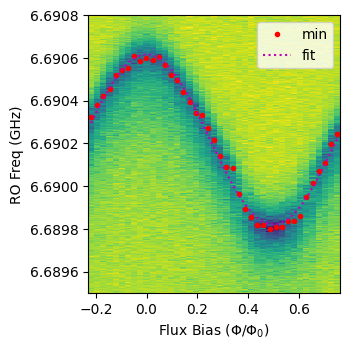

In [85]:
phi_norm1 = Vdc_to_flux_quanta(Vdc=flux_va, Vc=Vc1.n, Voffs=Voffs1.n) #expressed in phi0

#plot data

wfig=8.6
fig = plt.figure(constrained_layout=True, figsize=(1*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
#scaling factor
a1 = 1/phi0

#plots
ax1 = fig.add_subplot(spec[0, 0]) #photon power dependence with super-imposed min and fits
ax1.pcolormesh(phi_norm1*a1, f_ro_f, flux_amp2D_dB) #in dB
ax1.plot(phi_norm1*a1, freq_min_dip, 'r.', label='min') #superimposed peak minimum
ax1.plot(phi_norm1*a1, freq_fit1, 'm:', label='fit')
ax1.set_xlabel(r'Flux Bias ($\Phi/\Phi_{0}$)')
ax1.set_ylabel('RO Freq (GHz)')
ax1.legend(loc='best')
plt.show()

Assuming we have a flux tunable transmon, the cavity-pulling effect seemed reasonable.

##Method 2: Using resonator/qubit fitting functions.

This method makes use of fitting functions per measurement trace. The method is time consuming, as it fits data in less than a minute but it gives more information of the qubit properties. This algorithm is challenging to run. However, this method is more preferred in predicting qubit flux dependences, and performing in-depth rate characterization.

Here, we introduce two packages: notch fits for resonators, and Lorentzian fits for hangers. We introduce an iterative fitting scheme that is applicable also to hanger resonator fits made by Sebastian Probst [1].

### Resonator Spectroscopy Subroutine Fits

In [66]:
def notch_fit(xdata, ydata, show=['N','N'], *args):
    """
    Determine Parameters for cavity data - best use other python package
    python 3.7.6 for the fit

    Best use old python script for the fitting.

    Parameters
    ----------
    xdata : 1D numpy array
        frequency.
    ydata : 1D numpy array
        z-data (I + 1j*Q) => complex.
    show : list of strings
        show[0] : show fit report
            'Y' or 'N'
        show[1] : show fit behavior
            'Y' or 'N'
    *args : list of numbers
        args[0] : nominal cal input power in dB
        args[1] : flux value
        args[2] : xy power
        args[3] : xy frequency

    Returns
    -------
    out.best_fit: 1D numpy array
        Best Fit
    out.fit_val_stderr: dictionary
        {label: [nominal value, stderr]}

    """

    e1 = 1E9 # Gigahertz
    port1 = circuit.notch_port()
    port1.add_data(f_data=xdata*e1, z_data=ydata)
    port1.autofit()

    """Extract best fitting parameters from auto-fit"""
    dict_pars = port1.fitresults

    """Other results"""
    delay, a, alpha, fr, Ql, A2, fr = port1.do_calibration(f_data=xdata*e1, z_data=ydata)

    #small flux do not affect the calibration of the resonators

    if show[0] == 'Y':
        print("Fit results:", port1.fitresults)

    if show[1] == 'Y':
        port1.plotall()

    """Repackage data into 1 dictionary"""
    dict_pars_new = {'fr': [dict_pars['fr'], dict_pars['fr_err']],
                     'Ql': [dict_pars['Ql'], dict_pars['Ql_err']],
                     'Qi_dia_corr': [dict_pars['Qi_dia_corr'], dict_pars['Qi_dia_corr_err']],
                     'absQc': [dict_pars['absQc'], dict_pars['absQc_err']],
                     'phi0': [dict_pars['phi0'], dict_pars['phi0_err']],
                     'a': [a, 0],
                     'n_p': [port1.get_photons_in_resonator(power=args[0], unit='dBm'),0]}

    """Output Normalized Fit Function"""
    # pars = port1.do_calibration(f_data=xdata*e1, z_data=ydata)

    """Plot Bare Fitting function for Notch Port"""
    z_fit = port1.z_data_sim_norm

    """Extract Normalized z_data"""
    #currently does not correct phase but this is not the problem
    #non-zero alpha and delay
    # z_cal = port1.do_normalization(f_data = xdata, z_data=ydata, delay=pars[0],
    #                                amp_norm=pars[1], alpha=pars[2],
    #                                A2=pars[5], frcal=pars[3])

    #corrected data
    z_cal = port1.z_data
    #zero alpha and delay
    # z_cal = port1.do_normalization(f_data = xdata, z_data=ydata, delay=0,
    #                                amp_norm=pars[1], alpha=0,
    #                                A2=pars[5], frcal=pars[3])

    return [z_cal, z_fit], dict_pars_new

def autofit_notch(x2D_data, y2D_data, xlim, axes_label, var_arr, args, t=0.5):
    """
    Extract 2D map parameters with automated lor-fit function for further
    processing.

    Parameters
    ----------
    x2D_data : 2D numpy array
        x-axis.
    y2D_data : 2D numpy array
        y-axis.
    xlim : list of list
        i = variable arrays based on variable lengths
    axes_label : list
        axes_label[0] = x
        axes_label[1] = y
    var_arr : 1D numpy array
        variable effects.
    args : list
        args[0] = flux
        args[1] = mode (rop or flux)
        args[2] = save_params ['Y', 'filename']
        args[3] = drive power
        args[4] = drive frequency

    t : TYPE, optional
        DESCRIPTION. The default is 0.5.

    Returns
    -------
    yi_pars_val_stderr: list of dictionary.
        Analyzed data
    """

    n = len(x2D_data) #knowing the number of rows curves available from database

    #define the variable dictionary
    var_dic = {args[1]: var_arr}

    #store the extracted data in a list
    yi_pars = [dict() for x in range(n)]
    for i in range(n):
        """Optional: put time delays for this extraction. The core need for these
        fits is to extract the yi_parameters for better study"""
        x, idx_min, idx_max = freq_range(x2D_data[i], xlim[i][0], xlim[i][1])
        #print(len(x))

        """In notch fit, the parameters are ROP_dBm, and flux. We then add
        drive power for driving the qubit in the excited state."""
        if args[1] == 'rop_dBm':
            #print('xdata [' + str(i) + '] =' + str(len(x2D_data[i][idx_min:idx_max])))
            #print('ydata [' + str(i) + '] =' + str(len(y2D_data[i][idx_min:idx_max])))
            yical, yi_params = notch_fit(x2D_data[i][idx_min:idx_max],
                                         y2D_data[i][idx_min:idx_max],
                                         ['N','N'], var_arr[i], args[0])
            name='dBm (RO)'
            rnd_deg = 1
        elif args[1] == 'flux_V':
            yical, yi_params = notch_fit(x2D_data[i][idx_min:idx_max],
                                         y2D_data[i][idx_min:idx_max],
                                         ['N','N'], args[0], var_arr[i])
            name='V/A (flux quantum)'
            rnd_deg = 6
        else:
            """Can be drive frequency and power"""
            yical, yi_params = notch_fit(x2D_data[i][idx_min:idx_max],
                                         y2D_data[i][idx_min:idx_max],
                                         ['N','N'], var_arr[i], args[0])
            name='arb unit'

        """Show fit"""
        wfig = 8.6
        fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(wfig),
                                                           1*cm_to_inch(wfig)))

        spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
        ax1 = fig.add_subplot(spec[0, 0])
        ax2 = fig.add_subplot(spec[0, 1])

        ax1.set_title('Calibrated |S21|,' + '\n' + ' params=' + str(round(var_arr[i],rnd_deg))+' ' + name)
        ax1.plot(x2D_data[i][idx_min:idx_max], 20*np.log10(np.abs(yical[0])),
                 'k.', label='Exp')
        ax1.plot(x2D_data[i][idx_min:idx_max], 20*np.log10(np.abs(yical[1])),
                 'r-', label='Fit')
        ax1.set_xlabel('Frequency (GHz)')
        ax1.set_ylabel('S21 (dB)')

        ax2.set_title('Calibrated S21_phase,' + '\n' + 'params=' + str(round(var_arr[i],rnd_deg))+' ' + name)
        ax2.plot(x2D_data[i][idx_min:idx_max], np.angle(yical[0]),
                 'k.', label='Exp')
        ax2.plot(x2D_data[i][idx_min:idx_max], np.angle(yical[1]),
                 'r-', label='Fit')
        ax2.set_xlabel('Frequency (GHz)')
        ax2.set_ylabel('S21 (radians)')

        plt.show()

        """save data in a temporary dictionary"""
        yi_pars[i] = yi_params
        time.sleep(t)

    """The script returns arrays of datasets to which the data provides info of
    the extracted figures"""
    yi_params_dic = dict_retriv_form(data_dic=yi_pars,
                                     ctrl_dic=var_dic, save=args[2])

    return yi_params_dic

We analyze the same flux-dependent database using the hanger fit, which is more accurate in extracting resonant frequencies of the cavity. The model automatically accounts for linewidth asymmetries due to impedance mismatch between the resonator and the feedlines.

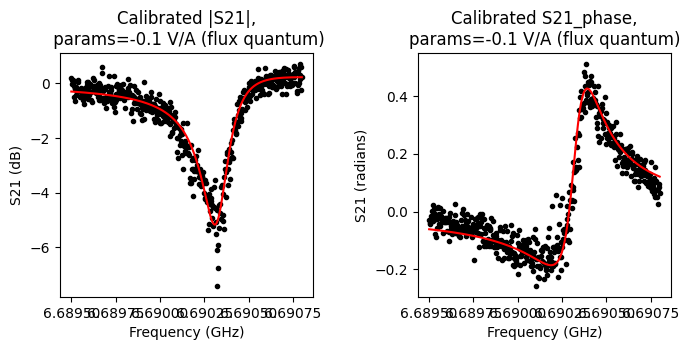

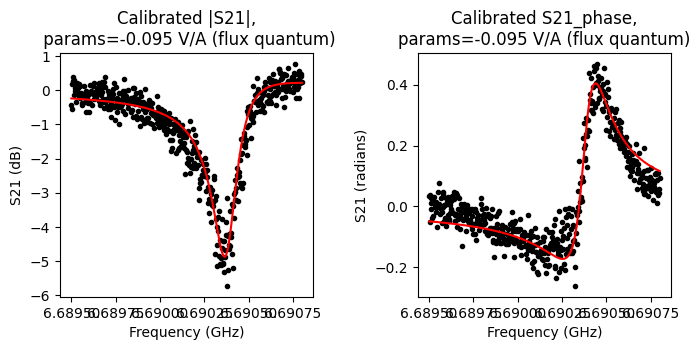

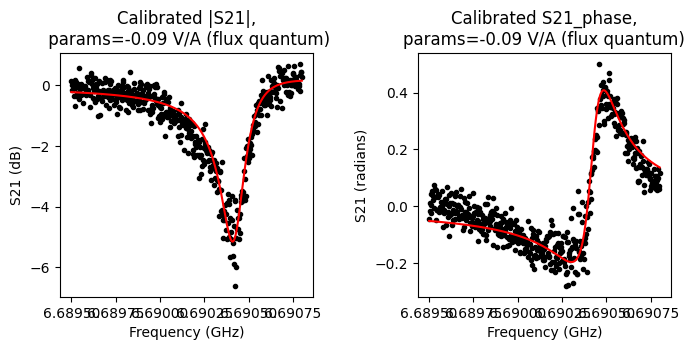

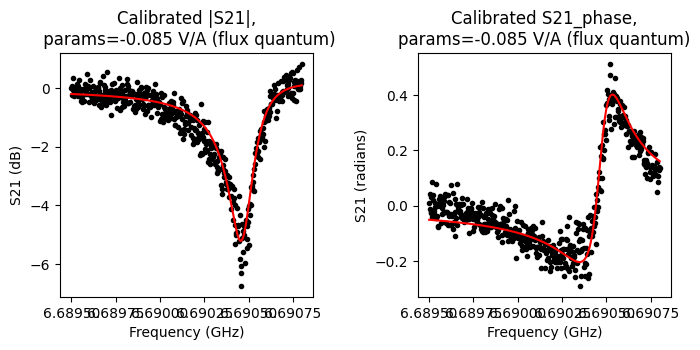

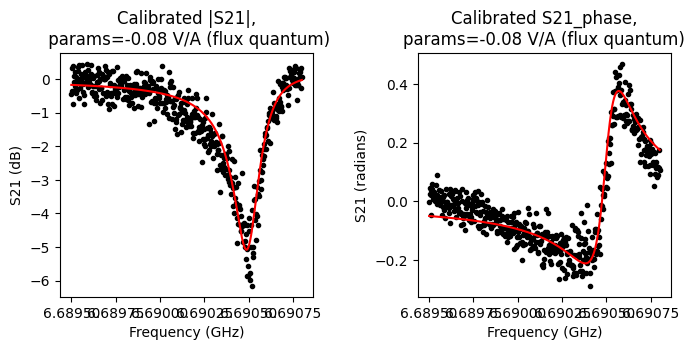

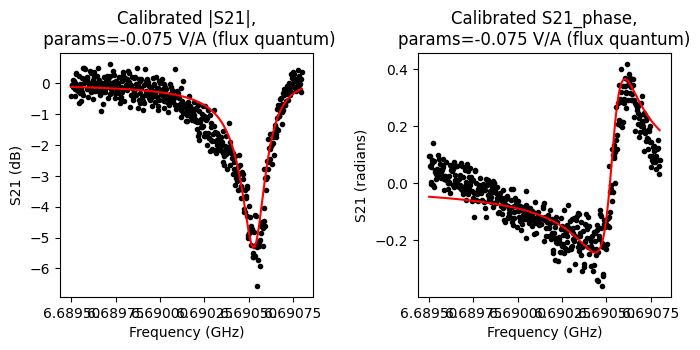

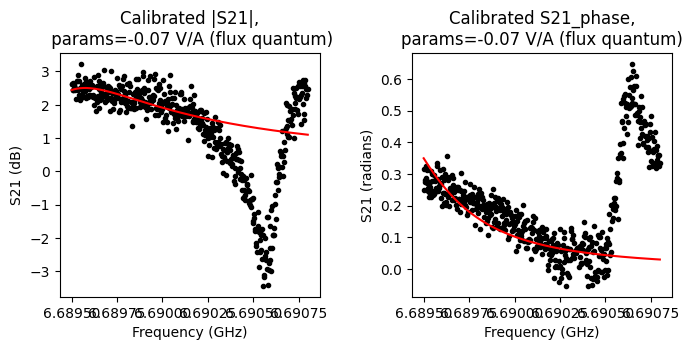

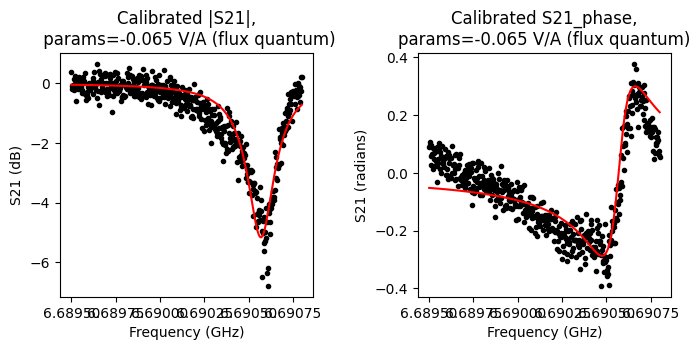

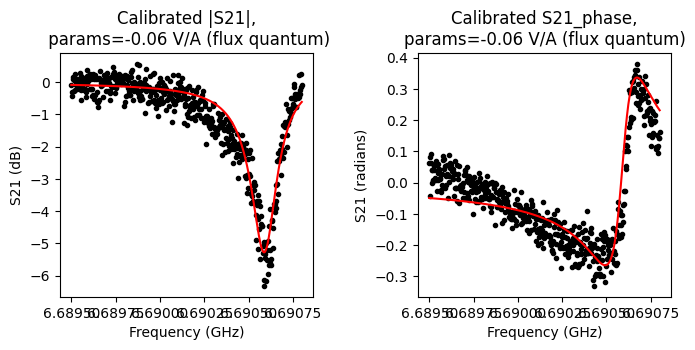

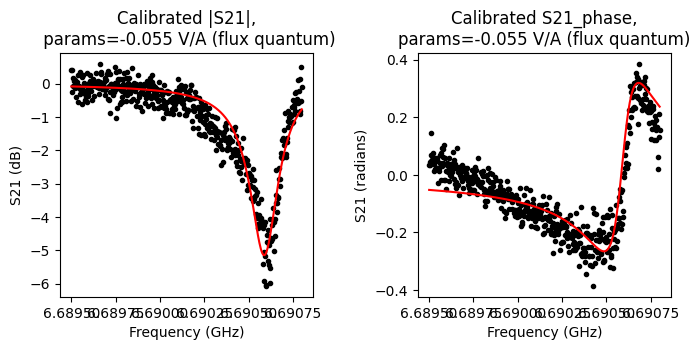

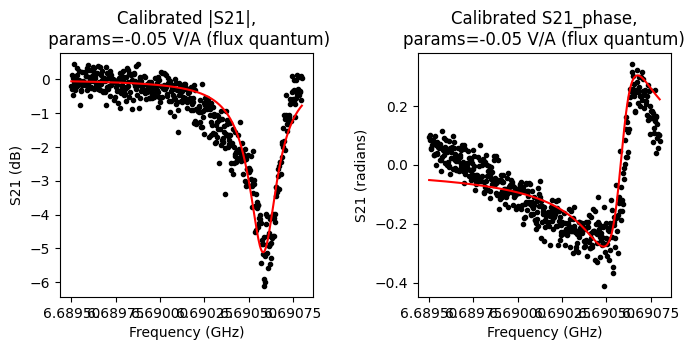

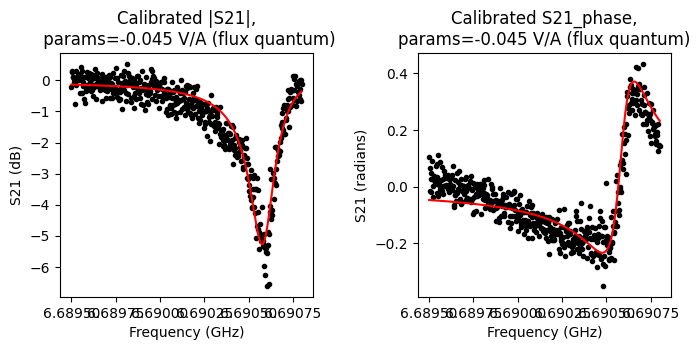

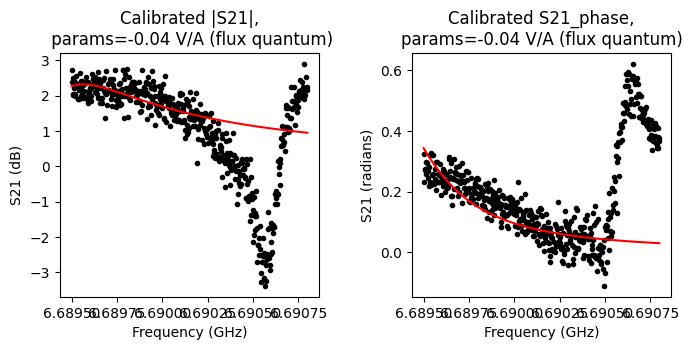

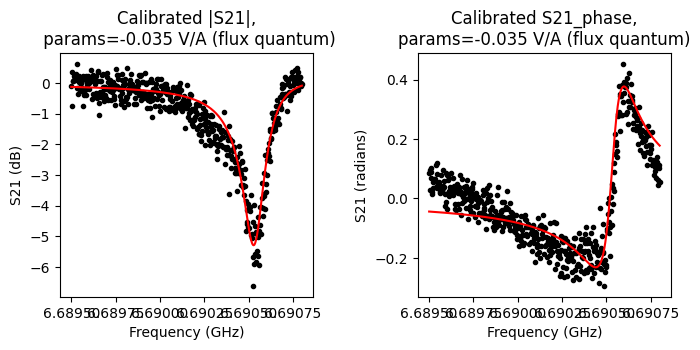

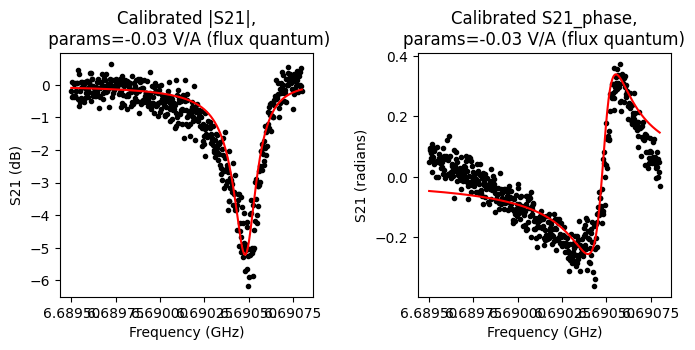

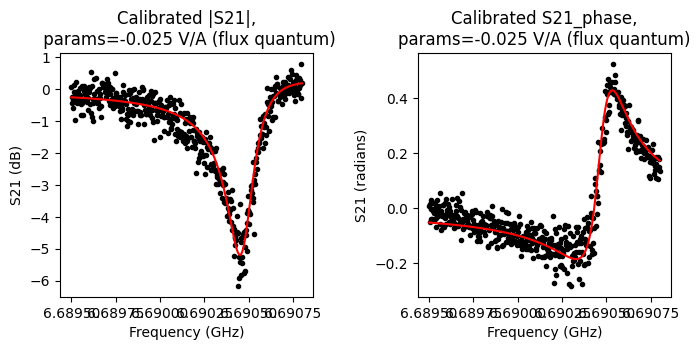

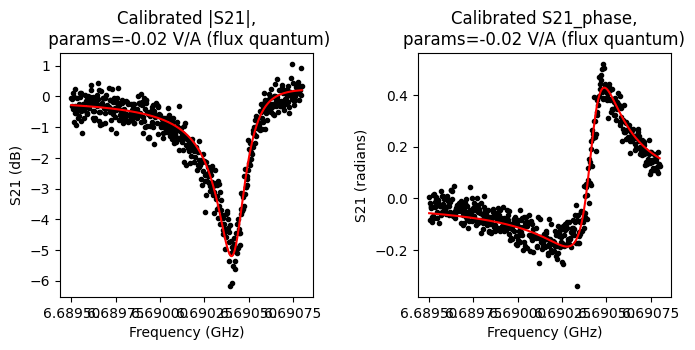

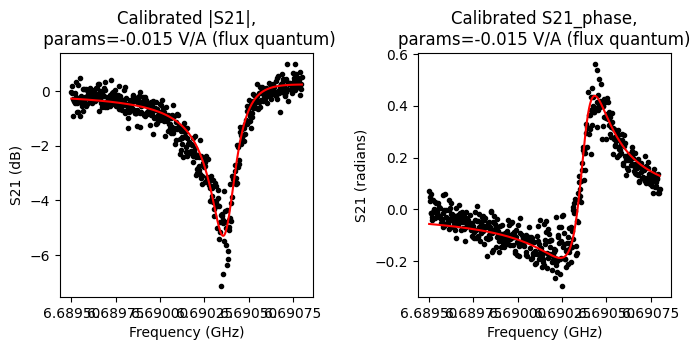

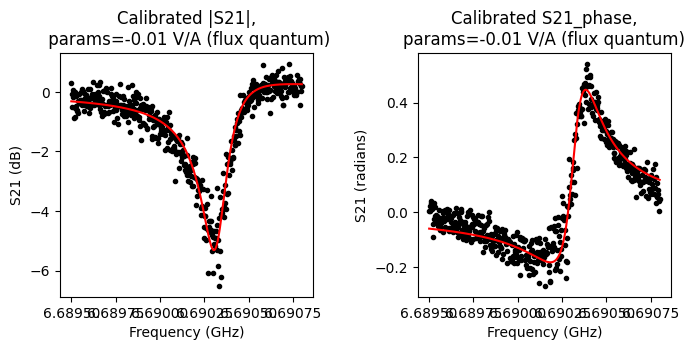

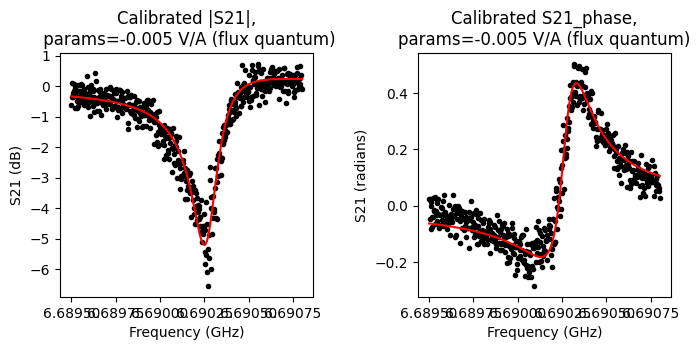

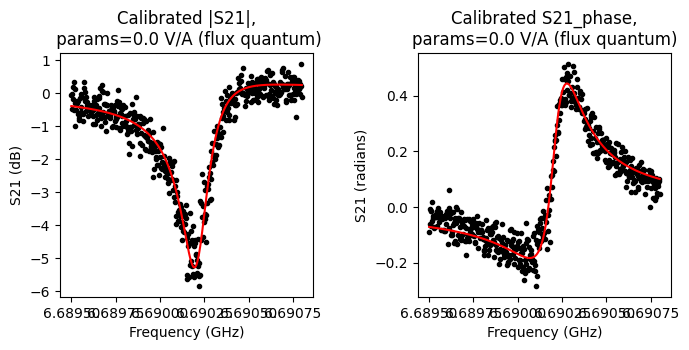

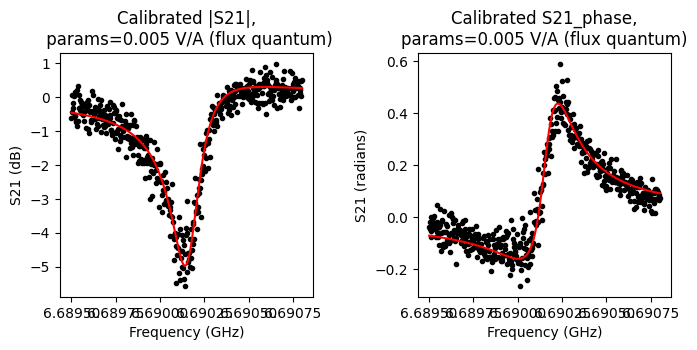

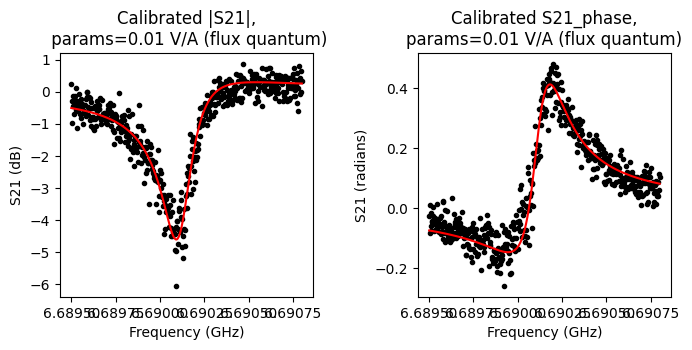

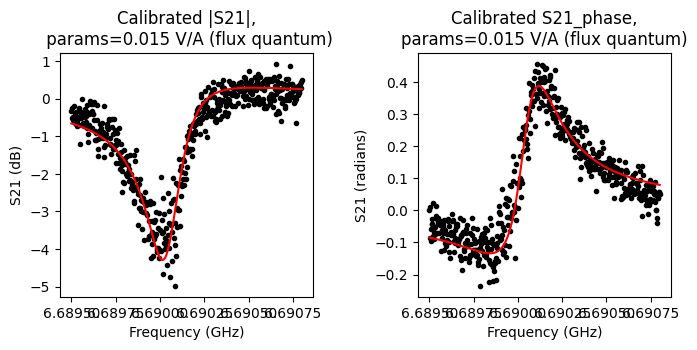

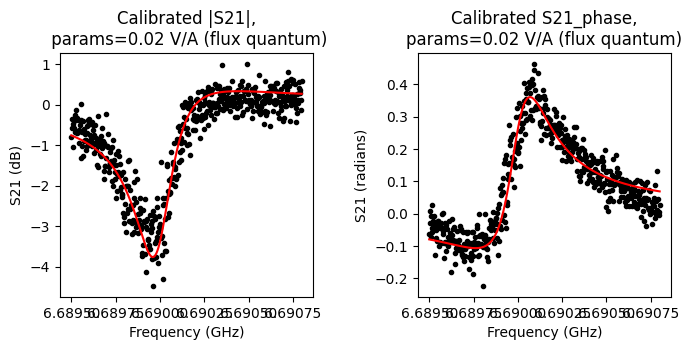

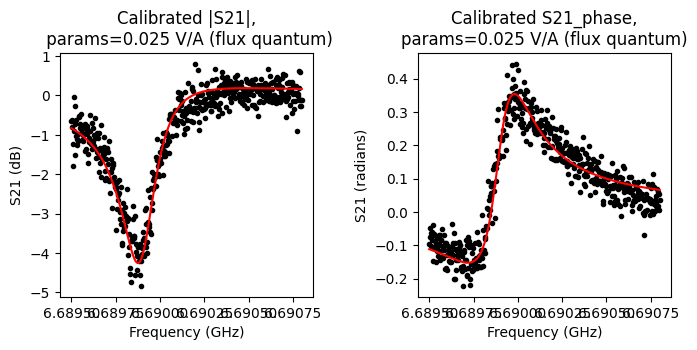

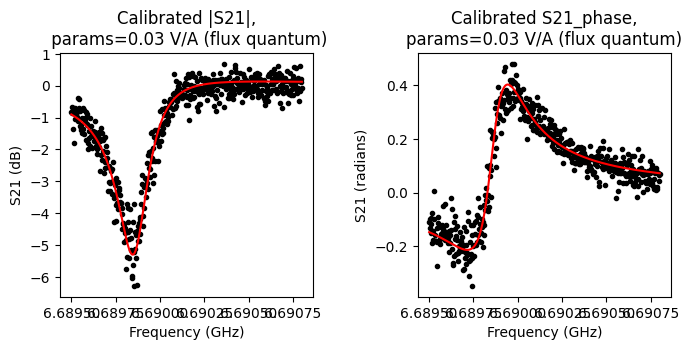

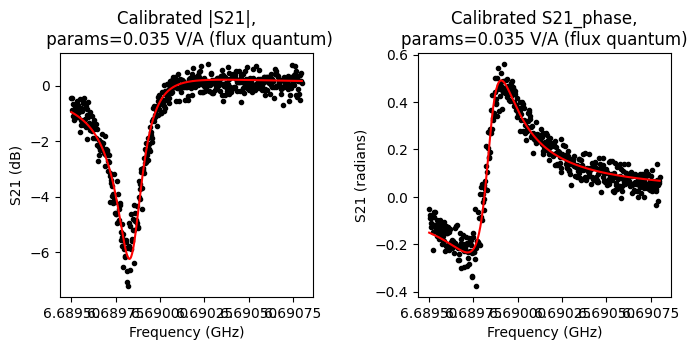

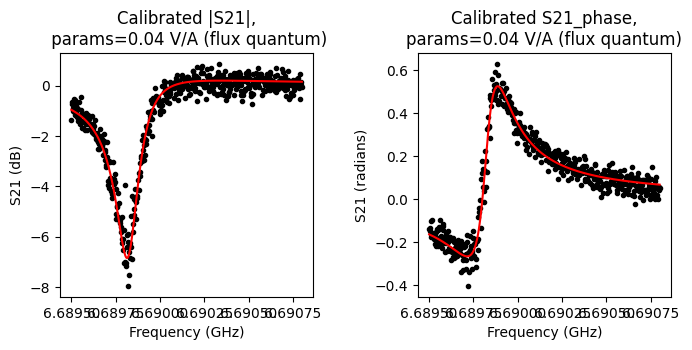

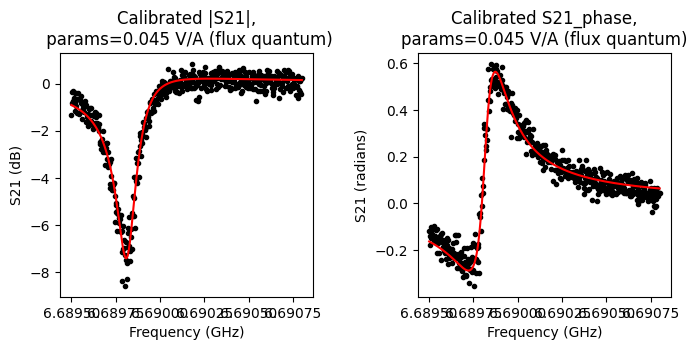

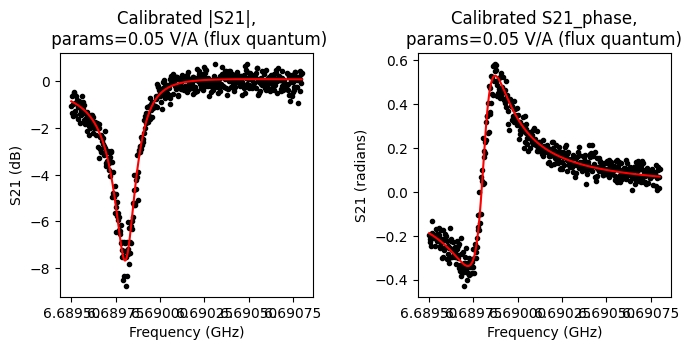

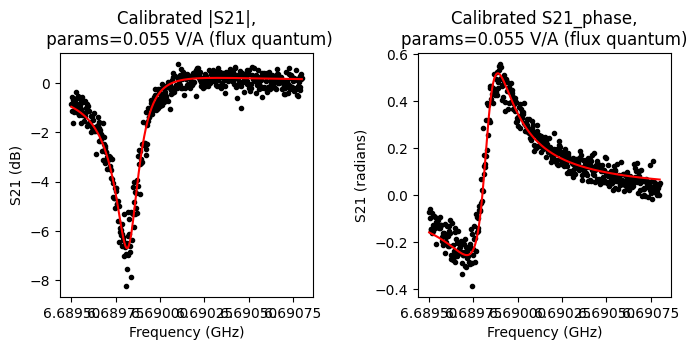

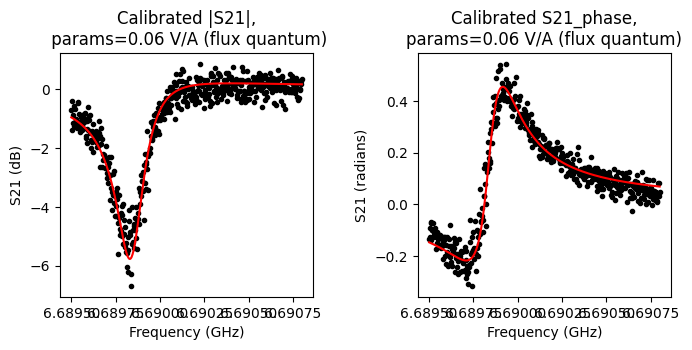

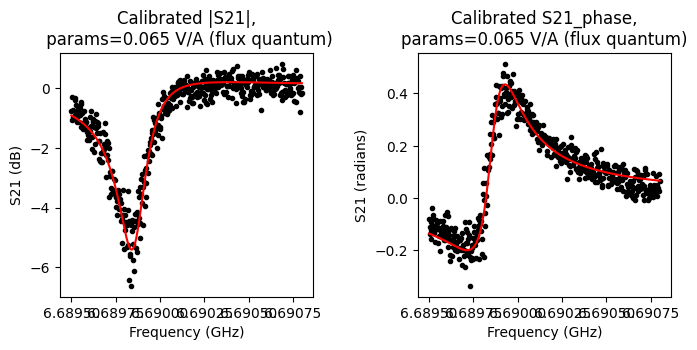

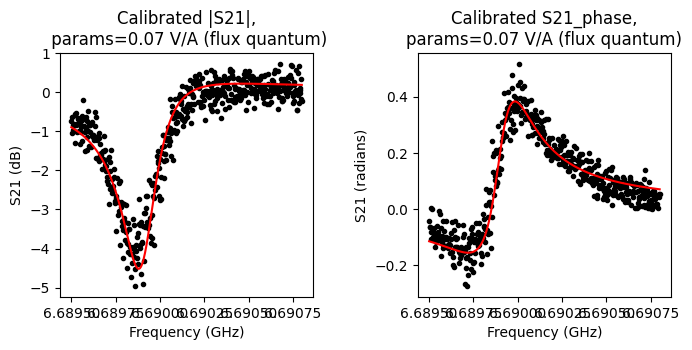

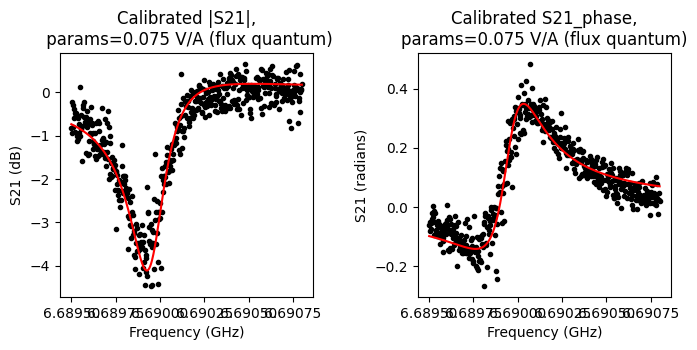

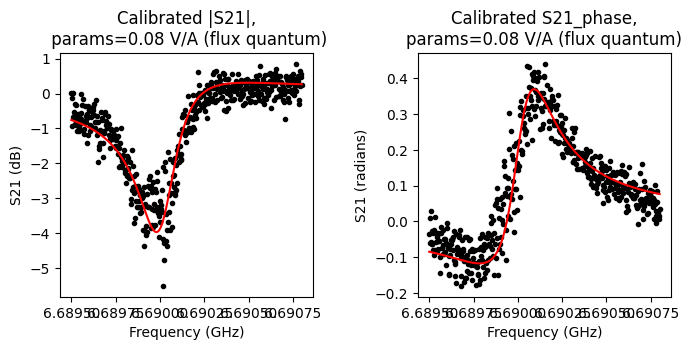

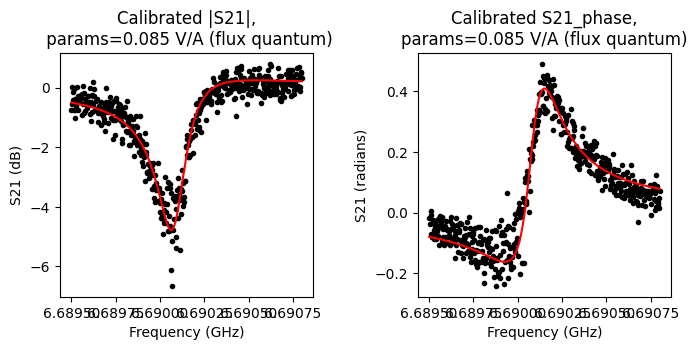

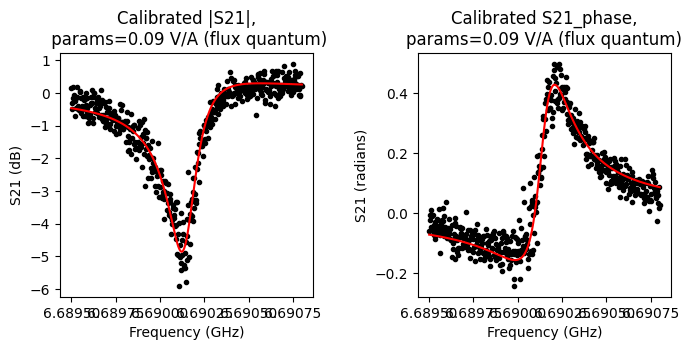

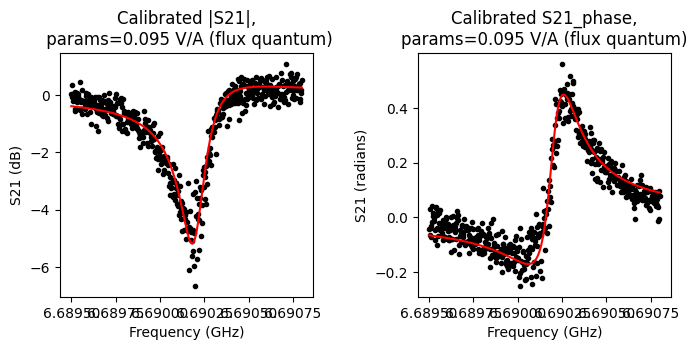

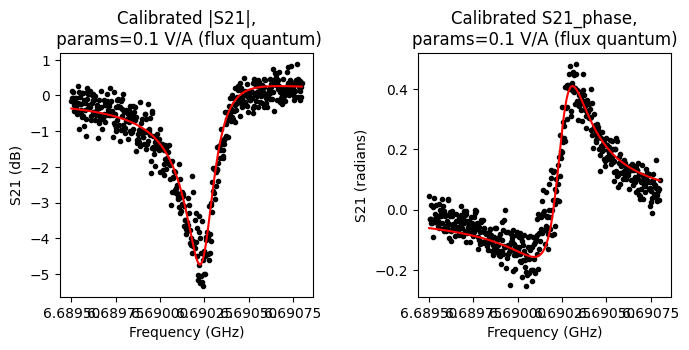

In [69]:
fname_res_flux = 'Flux-Dependent Bias IF=500 Freq=6691 GHz S21-FreqResp_vs_ProbePow'
#get flux amplitude and phase from resonator data
dict_flux_C2 = get_data_from_mat(fname_res_flux)

"""variable dimensions"""
flux_va = dict_flux_C2['x'][0] #flux bias in Volts, 41 points
f_ro_f = dict_flux_C2['y'][0] #readout frequency, 501 points

"""For analysis"""
flux_I2D = np.transpose(dict_flux_C2['ZZI']) #in V_ratio
flux_Q2D = np.transpose(dict_flux_C2['ZZQ']) #in V_ratio
n = flux_I2D.shape[0] #26
zflux_2D = [flux_I2D[i,:] + 1j*flux_Q2D[i,:] for i in range(len(flux_I2D))]
f_2D_f = np.asarray([f_ro_f for i in range(n)]) #for 2D map analysis

"""Auxilliary data"""
rop_flux_dBm = -50 #in dBm, applied probe power
rop_calf_dBm = rop_flux_dBm + -81

"""data"""
freq_lim_f = [[f_ro_f[0], f_ro_f[-1]] for i in range(n)]
# do automated fitting. for best analysis, better retrieve the data in the flux_C2Q2_params
dict_flux_eval = autofit_notch(x2D_data=f_2D_f, y2D_data= zflux_2D,
                               xlim=freq_lim_f, axes_label=[],
                               var_arr=flux_va,
                               args=[rop_calf_dBm, 'flux_V',
                                ['Y','flux_C2Q2_params']], t=0.05)

Some of the fits fail, which means that one must have a better frequency span so that the fit would not fail. Perform the fit during measurement, and see if the fit works for all parameters, before proceeding to measure.

The hanger fit contains more parameters aside from frequency and Q-factor, that would be of interest in new qubit devices. For now, we focus on retrieving resonant frequency fits from the .mat file.



[[Model]]
    Model(cos_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 26
    # data points      = 41
    # variables        = 4
    chi-square         = 2.8961e-06
    reduced chi-square = 7.8273e-08
    Akaike info crit   = -667.094644
    Bayesian info crit = -660.240356
    R-squared          = 0.34674007
[[Variables]]
    period:  30.1639763 +/- 3.80314155 (12.61%) (init = 24.1661)
    amp:     2.7169e-04 +/- 6.3559e-05 (23.39%) (init = 0.0004195721)
    phi0:   -1.66853514 +/- 0.22968041 (13.77%) (init = -1.884956)
    b:       6.69017783 +/- 4.3839e-05 (0.00%) (init = 6.690177)


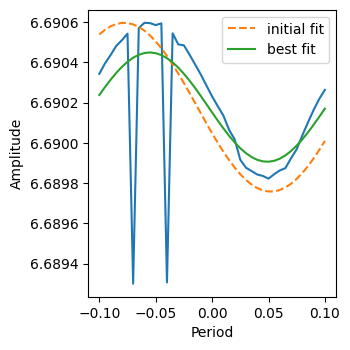

[[Model]]
    Model(cos_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 40
    # data points      = 39
    # variables        = 4
    chi-square         = 2.5511e-08
    reduced chi-square = 7.2890e-10
    Akaike info crit   = -816.760406
    Bayesian info crit = -810.106159
    R-squared          = 0.99097282
[[Variables]]
    period:  30.6330845 +/- 0.25565401 (0.83%) (init = 10.13417)
    amp:     3.8573e-04 +/- 6.4312e-06 (1.67%) (init = 0.0003747363)
    phi0:   -1.66961086 +/- 0.01565325 (0.94%) (init = -1.884956)
    b:       6.69023999 +/- 4.3428e-06 (0.00%) (init = 6.690222)


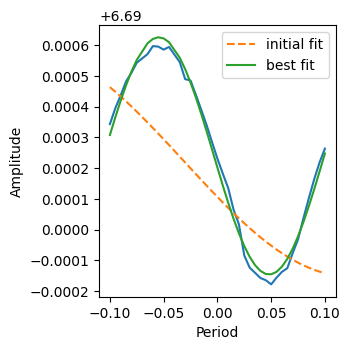

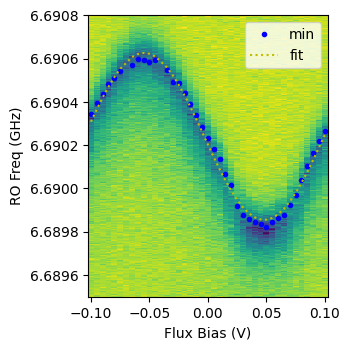

In [83]:
from scipy.stats import friedmanchisquare
#retrieve cavity frequency and error bar
dict_flux_eval = get_data_from_mat(filename = 'flux_C2Q2_params')
flux_A2 = dict_flux_eval['flux_V'][0] #remember that this was converted to 2D array
fr_flux_n = dict_flux_eval['fr'][0] #nominal values from fit, data expressed in GHz from fit
fr_flux_str = dict_flux_eval['fr'][1] #std_dev

#fit cavity frequency shift
b2 = 1E-9 # scaling factor from Hz to GHz
freq_fit2, dict_cos2 = lm_cos_fit(xdata=flux_A2, ydata=fr_flux_n*b2, show=['Y','Y'])

"""
We see that idx= has an unexpected offshoot compared to the other data. This is
because of the limit of bandwidth of the measurement. The best way to 'massage'
the data without affecting outliers would be to discard the offshot data this
would result in unequal database but at least we improve the analysis
"""

#points to be deleted
idx_e1 = 6
idx_e2 = 12

flux_A2_mod = np.delete(flux_A2, [idx_e1, idx_e2])
fr_flux_n_mod = np.delete(fr_flux_n, [idx_e1, idx_e2])
fr_flux_str_mod = np.delete(fr_flux_str, [idx_e1, idx_e2])

freq_fit2, dict_cos2 = lm_cos_fit(xdata=flux_A2_mod, ydata=fr_flux_n_mod*b2, show=['Y','Y'])

#Show compared data

#plot data

wfig=8.6
fig = plt.figure(constrained_layout=True, figsize=(1*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))

spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
ax1 = fig.add_subplot(spec[0, 0]) #photon power dependence with super-imposed min and fits
ax1.pcolormesh(flux_va, f_ro_f, flux_amp2D_dB) #in dB
ax1.plot(flux_A2_mod, fr_flux_n_mod*b2, 'b.', label='min') #superimposed peak minimum
ax1.plot(flux_A2_mod, freq_fit2, 'y:', label='fit')
ax1.set_xlabel('Flux Bias (V)')
ax1.set_ylabel('RO Freq (GHz)')
ax1.legend(loc='best')
plt.show()

#plot calibrated data according to flux


We redo the previous analysis using the peak minimum analysis to get an approximate calibration of the parameters, and recalibrate the qubit flux according to normalized flux quanta.

Report from Qubit
Voltage Period for flux quantum = 0.205 +/- 0.002 V
Voltage Offset = -0.055 +/- 0.001 V
Periodic Current = 2.093e-02 +/- 1.746e-04 A
Mutual Inductance = 98.818 +/- 0.825 fH
Mutual inductance in units of flux quanta = 47.788
Normalized Flux Offset = 0.266 +/- 0.004 phi0




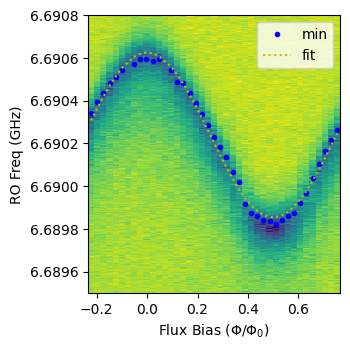

In [91]:
# the m here refers to the sensitivity to bias voltage to the room temperature DC voltage
Vc2 = m_to_Vc(ufloat(dict_cos2['period'][0], dict_cos2['period'][1]))
Voffs2 = theta0_to_offset(ufloat(dict_cos2['period'][0], dict_cos2['period'][1]),
                       ufloat(dict_cos2['phi0'][0], dict_cos2['phi0'][1]))
phi_e2 = Vdc_to_flux_quanta(Vdc=0, Vc=Vc2, Voffs=Voffs2)

#Converting Room Temperature AWG Voltages to Current and Inductance
attn_flux = 20 #dB
Ic2 = Vdc_to_Ic(Vdc=Vc2, attn=attn_flux)
m_Ic2 = 1/Ic2 #sensitivity of flux current
Lm2 = Lm(Ic=Ic2) #Mutual Inductance of the flux bias line with flux quanta
print('Report from Qubit')
print('Voltage Period for flux quantum = {:.3f} +/- {:.3f} V'.format(Vc2.n, Vc2.std_dev))
print('Voltage Offset = {:.3f} +/- {:.3f} V'.format(Voffs2.n, Voffs2.std_dev))
print('Periodic Current = {:.3e} +/- {:.3e} A'.format(Ic2.n, Ic2.std_dev))
print('Mutual Inductance = {:.3f} +/- {:.3f} fH'.format(Lm2.n*1E15, Lm2.std_dev*1E15)) #sensitivity to flux quanta
print('Mutual inductance in units of flux quanta = {:.3f}'.format(Lm2.n/phi0))
print('Normalized Flux Offset = {:.3f} +/- {:.3f} phi0'.format(phi_e2.n/phi0, phi_e2.std_dev/phi0))
print('\n')

#calibrate the plots according to flux quanta
phi_norm2 = Vdc_to_flux_quanta(Vdc=flux_va, Vc=Vc2.n, Voffs=Voffs2.n) #expressed in phi0
phi_norm2_mod = Vdc_to_flux_quanta(Vdc=flux_A2_mod, Vc=Vc2.n, Voffs=Voffs2.n) #expressed in phi0

#plot data

wfig=8.6
fig = plt.figure(constrained_layout=True, figsize=(1*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
#scaling factor
a1 = 1/phi0
b2 = 1E-9

#plots
ax1 = fig.add_subplot(spec[0, 0]) #photon power dependence with super-imposed min and fits
ax1.pcolormesh(phi_norm2*a1, f_ro_f, flux_amp2D_dB) #in dB
ax1.plot(phi_norm2_mod*a1, fr_flux_n_mod*b2, 'b.', label='min') #superimposed peak minimum
ax1.plot(phi_norm2_mod*a1, freq_fit2, 'y:', label='fit')
ax1.set_xlabel(r'Flux Bias ($\Phi/\Phi_{0}$)')
ax1.set_ylabel('RO Freq (GHz)')
ax1.legend(loc='best')
plt.show()

We see similar result but now the fitted line is not in the dip. This means that the accounted cavity frequency may not necessarily be located in the cavity dip due to mismatched lines. Nevertheless, these analysis give the salient physics of superconducting resonators. Now as a last benchmark, we compare the frequency fits between data points obtained at the minimum amplitude, and from the fits.

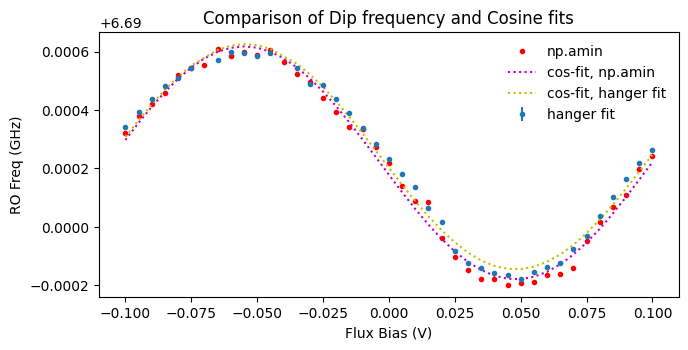

In [96]:
wfig=8.6
fig = plt.figure(constrained_layout=True, figsize=(2*cm_to_inch(wfig),
                                                   1*cm_to_inch(wfig)))
spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
#scaling factor
a1 = 1/phi0
b2 = 1E-9

#plots
ax1 = fig.add_subplot(spec[0, 0])
ax1.set_title('Comparison of Dip frequency and Cosine fits')
ax1.plot(flux_va, freq_min_dip, 'r.', label='np.amin')
ax1.plot(flux_va, freq_fit1, 'm:', label='cos-fit, np.amin')
ax1.errorbar(x=flux_A2_mod, y=fr_flux_n_mod*b2, yerr=fr_flux_str_mod*b2,
             fmt='.', color='tab:blue', label='hanger fit')
ax1.plot(flux_A2_mod, freq_fit2, 'y:', label='cos-fit, hanger fit')
ax1.set_xlabel(r'Flux Bias (V)')
ax1.set_ylabel('RO Freq (GHz)')
ax1.legend(loc='best', frameon=False)
plt.show()

We see little deviation in the period between methods, although the amplitude and offset of the cosine wave differ a little bit due to impedance mismatch. Nevertheless, the fitting algorithm looks promising as it can extract more features in a linewidth, as compared to the point method.

## Dispersive limit and flux-dependent cavity response

In the dispersive limit ($\omega_{c} < \omega_{q}$ and $n<=n_{crit}$), the cavity-qubit interaction is weak that both the cavity and the qubit pull each other's frequencies depending on their photon number $n$ and the detuning of the qubit from the cavity $\Delta=|\omega_{q}-\omega_{c}|$, with the assumption that the qubit frequency is far below the cavity frequency. In the cavity perspective, we introduce the dispersive shift term

$$\chi=\frac{g^2}{Δ}=-\frac{g_{01}^2}{\Delta}\frac{1}{1+(\Delta/\alpha)}$$

where $g^{2}=-g_{01}^{2}/(1+(\Delta/\alpha))$ is the effective coupling strength of qubit $g_{01}$ to the resonator with anharmonicity $\alpha=-E_{c}/\hbar$, the units of $\chi=2\pi f$ the cavity frequency is modified by the qubit through the relation

$$f_{c}^{'} = f_{c} + \frac{\chi}{2\pi}$$

When we apply flux to the qubit that is in the ground state, the $\Delta$ shifts as a function of flux $\Phi$, which in its uncalibrated form, is in the units of voltage for flux-biased lines. In the last applet, we introduce the dependence of the transmon with flux. Here, we integrate that knowledge in the dispersive shift of the cavity.

$$ \omega_{q,01}(\Phi) \approx \frac{1}{\hbar} \left( 8 \sqrt{E_{J}^{'}(\Phi)E_{C}} - E_{C} \right) $$.

In a realistic setting where the designed $\Delta \le 2\pi \times 1.2$ GHz (the parameter of current experiments), the detuning can be established as a first order.

$$\chi=\frac{g^2}{\omega_{c}}\frac{1}{\omega_{q}(\Phi)/\omega_{c}-1} \approx -\frac{g^2}{\omega_c} \left(1 - \frac{1}{2}\frac{\omega_{q}(\Phi)}{\omega_{c}} \right)$$

Inserting the transmon qubit frequency in the dispersive shift would give a complicated transmon formulation behavior. We use numerical models to plot the behavior of the transmon, and assume symmetric transmons. Then, we try to ascertain if the observed flux-tunable cavity response is consistent with the model. Just take note that the cosine fit is a good extracting model that can ascertain qubit periods, but not the $E_{J}$ ratios.

### Qubit Spectroscopy Subroutine Fits

In [ ]:
def guess_lor_base(xdata, ydata):
    """
    Get initial value based on the data

    Parameters
    ----------
    xdata : TYPE
        DESCRIPTION.
    ydata : TYPE
        DESCRIPTION.

    Returns
    -------
    None.

    """
    # determine guess resonant data
    idx_f0 = find_nearest(array=ydata, value=np.amax(ydata))[0]
    f0_guess = xdata[idx_f0]
    #print('Guess peak frequency = {:.3f}'.format(f0_guess))

    #guess half-width half max through amplitude => sigma
    y_hwhm = np.amin(ydata) + (np.amax(ydata)-np.amin(ydata))/2 #ok
    f_hwhm_left = xdata[find_nearest(array=ydata[:idx_f0], value=y_hwhm)[0]]
    f_hwhm_right = xdata[int(idx_f0 + find_nearest(array=ydata[idx_f0:], value=y_hwhm)[0])]
    if np.abs(f0_guess-f_hwhm_left) >= np.abs(f_hwhm_right-f0_guess):
        del_f_hwhm = np.abs(f0_guess-f_hwhm_left)
        f_hwhm = f_hwhm_left #needed for searching for data hwhm
    else:
        del_f_hwhm = np.abs(f_hwhm_right-f0_guess)
        f_hwhm = f_hwhm_right #needed for searching for data hwhm
    #print('Guess f_HWHM (sigma) = {:.3f}'.format(del_f_hwhm))

    #guess amplitude = height*np.pi*sigma for lorentzian by getting the height at hwhm
    hwhm = ydata[np.where(xdata == f_hwhm)[0][0]]
    amp_guess = hwhm*np.pi*del_f_hwhm
    #print('Guess y_HWHM (amplitude) = {:.3e}'.format(amp_guess))

    #guess baseline data - remove the x and y data that involves the peak data
    idx_ybase = np.where((xdata < (f0_guess-2*del_f_hwhm)) | (xdata > (f0_guess+2*del_f_hwhm)))
    y_base_avg = np.average(ydata[idx_ybase])
    #print(y_base_avg)

    dict_guess = {'pk_center': f0_guess,
                  'pk_sigma': del_f_hwhm,
                  'pk_amplitude': amp_guess,
                  'const_c': y_base_avg}
    return dict_guess

def lor_base_fit(xdata, ydata, show=['N','N'], *args):
    """
    Lorentzian fit of amplitude plots

    Ver 1: easy fitting of baseline

    Ver 2: improved dictionary retrieval. However, two-tone spectroscopy data
    and power spectral density necessitates unneeded calibration. However,
    additional information must be included.

    Parameters
    ----------
    xdata : 1D numpy array
        x-data.
    ydata : 1D numpy array
        y-data.
    show: list of strings
        show[0] : show fit report
            'Y' or 'N'
        show[1] : show fit behavior
            'Y' or 'N'
    case 1: two-tone
    *args: list of numerical arguments
        args[0] = ROP (readout power)
        args[2] =

    Returns
    -------
    out_best_fit : 1D numpy array
        best fit y-values
    out_best_dict : dict
        dictionary of {params: [val, stderr]}
        params = ['pk_center', 'pk_fwhm', 'pk_height', 'const_c']
    """

    #make guess function
    dict_g = guess_lor_base(xdata, ydata)

    #make a model
    #baseline is the dip of the notch at cavity resonance
    const = ConstantModel(prefix='const_')

    pars = const.guess(ydata, x=xdata)

    """lorentzian is the shift of the dip due to drive. Similar to OMIT.
    The baseline can be extracted from cavity dip."""

    Lor = LorentzianModel(prefix='pk_')
    pars.update(Lor.make_params(center=dict(value=dict_g['pk_center'],
                                            min=xdata[0], max=xdata[-1]),
                                sigma=dict(value=dict_g['pk_sigma'],
                                           min=xdata[1]-xdata[0],
                                           max=xdata[-1] - xdata[0]),
                                amplitude=dict(value=dict_g['pk_amplitude'],
                                               min=0,
                                               max=np.amax(ydata)*np.pi*dict_g['pk_sigma']))) #2*amp)))

    """Amplitude Fit with fit"""
    mod = const + Lor
    init = mod.eval(pars, x=xdata)
    out = mod.fit(ydata, pars, x=xdata)

    if show[0] == 'Y':
        #print out fitting report
        print(out.fit_report(min_correl =0.3))

    if show[1] == 'Y':
        #show amplitude fit
        fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
        axes[0].plot(xdata, ydata)
        axes[0].plot(xdata, init, '--', label='initial fit')
        axes[0].plot(xdata, out.best_fit, '-', label='best fit')
        axes[0].set_xlabel('Frequency (GHz)')
        axes[0].set_ylabel('Amplitude (P-Ratio)')
        axes[0].legend()

        comps = out.eval_components(x=xdata)
        axes[1].plot(xdata, ydata)
        axes[1].plot(xdata, comps['const_'], '--', label='Linear Background')
        axes[1].plot(xdata, comps['pk_'], '--', label='Lorentzian component')
        axes[1].set_xlabel('Frequency (GHz)')
        axes[1].set_ylabel('Amplitude (P-Ratio)')
        axes[1].legend()
        plt.show()

        #phase data not included

    """--Retrieve String from the fit function--output is x-fit and y-fit-------"""
    name = ['pk_center', 'pk_fwhm', 'pk_height','const_c']
    # strange dictionary
    out_dict_val_stderr = {name[i]: [out.params[name[i]].value,
                                    out.params[name[i]].stderr] for i in range(len(name))}

    return out.best_fit, out_dict_val_stderr

def autofit_lor_base(x2D_data, y2D_data, xlim, axes_label, var_arr, args, t=0.5):
    """
    Extract 2D map parameters with automated lor-fit function for further
    processing. Purpose is on stark calibration and noise measurements.

    Ver 1. list of dictionaries. Each dictionary contains a list of two
    elements first element is nominal value and second element is the error
    of the fit

    Ver 2. dictionaries that contains a list of 2 arrays. The first array
    is the nominal array and the second is the error of the fit array.
    The dictionary can be easily save in.mat file for later processing. Based
    on extraction of data by lor_base_fit2.

    No urgent calibration on amplitude needed.

    Parameters
    ----------
    x2D_data : 2D numpy array
        x-axis.
    y2D_data : 2D numpy array
        y-data - (amplitude only in P-ratio. Phase not included).
    xlim : list of list
        i = variable arrays based on variable lengths
    axes_label : list
        axes_label[0] = x
        axes_label[1] = y
    var_arr : 1D numpy array
        variable effects. (rop)
    args : list
        args[0] = flux (for device offset)
        args[1] = mode (rop or flux)
        args[2] = save_params ['Y', 'filename']
        args[3] = drive power
        args[4] = drive frequency

    Returns
    -------
    yi_pars_val_stderr: list of dictionary.
        Analyzed data
    """

    n = len(x2D_data) #knowing the number of rows curves available from database

    #define the variable dictionary
    var_dic = {args[1]: var_arr}

    yi_pars = [dict() for x in range(n)]
    for i in range(n):
        """Optional: put time delays for this extraction. The core need for these
        fits is to extract the yi_parameters for better study"""
        """plot is working. core issue is the extraction of the params for analysis"""
        x, idx_min, idx_max = freq_range(x2D_data[i], xlim[i][0], xlim[i][1])
        #print(len(x))
        yifit, yi_params = lor_base_fit(x2D_data[i][idx_min:idx_max],
                                        y2D_data[i][idx_min:idx_max],
                                        show=['N','N'])

        #args will not yet be inputted

        """Show fit, amplitude and phase fit"""
        """In lor-base fit, the parameters are ROP_dBm, flux and drive power"""
        if args[1] == 'rop_dBm':
            #print('xdata [' + str(i) + '] =' + str(len(x2D_data[i][idx_min:idx_max])))
            #print('ydata [' + str(i) + '] =' + str(len(y2D_data[i][idx_min:idx_max])))
            yifit, yi_params = lor_base_fit(x2D_data[i][idx_min:idx_max],
                                            y2D_data[i][idx_min:idx_max],
                                            show=['N','N'])
            name='dBm (RO)'
            rnd_deg = 1
        elif args[1] == 'flux_V':
            yifit, yi_params = lor_base_fit(x2D_data[i][idx_min:idx_max],
                                              y2D_data[i][idx_min:idx_max],
                                              ['N','N'], args[0], var_arr[i])
            name='V/A (flux quantum)'
            rnd_deg = 6
        else:
            """Can be xy frequency and power - to be added later"""
            yifit, yi_params = lor_base_fit(x2D_data[i][idx_min:idx_max],
                                              y2D_data[i][idx_min:idx_max],
                                              ['N','N'], var_arr[i], args[0])
            rnd_deg = 1
            name='arb unit'

        """Show fit"""
        wfig = 8.6
        fig = plt.figure(constrained_layout=True, figsize=(1*cm_to_inch(wfig),
                                                           1*cm_to_inch(wfig)))

        spec = gridspec.GridSpec(ncols=1, nrows=1, figure=fig, hspace =0.05, wspace=0.1)
        ax1 = fig.add_subplot(spec[0, 0])

        ax1.set_title('Raw Freq Response,' + '\n' + ' params=' + str(round(var_arr[i],rnd_deg))+' ' + name)
        ax1.plot(x2D_data[i][idx_min:idx_max], 10*np.log10(np.abs(y2D_data[i][idx_min:idx_max])),
                 'k.', label='Exp')
        ax1.plot(x2D_data[i][idx_min:idx_max], 10*np.log10(np.abs(yifit)),
                 'r-', label='Fit')
        ax1.set_xlabel('Frequency (GHz)')
        ax1.set_ylabel('Uncal S21 (dB)')

        plt.show()

        yi_pars[i] = yi_params
        time.sleep(t)

    """The script returns arrays of datasets to which the data provides info of
    the extracted figures"""
    yi_params_dic = dict_retriv_form(data_dic=yi_pars,
                                     ctrl_dic=var_dic, save=args[2])

    return yi_params_dic

#References:
1. Probst, S., Song, F. B., Bushev, P. A., Ustinov, A. V., & Weides, M. (2015). Efficient and robust analysis of complex scattering data under noise in microwave resonators. Rev Sci Instrum, 86(2), 024706. doi:10.1063/1.4907935
2. Data in Courtesy of Li-Chieh Hsiao and Prof. Chii Dong Chen of the Quantum Electronics Laboratory in Academia Sinica.